In [1]:
# Hücre 1 - Ortam kontrolü
import sys, os
print("Python:", sys.version.splitlines()[0])
try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
except Exception as e:
    print("TensorFlow import hatası:", e)

# GPU
!nvidia-smi || true

# Kaggle kurulumu
!pip install -q kaggle


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
Thu Oct  2 14:34:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                   

In [2]:
# Hücre 2
import os, shutil
if os.path.exists('kaggle.json'):
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("kaggle.json /root/.kaggle/kaggle.json olarak yüklendi.")
else:
    print("kaggle.json bulunamadı. Lütfen sol panelden upload edin (Files -> Upload).")


kaggle.json /root/.kaggle/kaggle.json olarak yüklendi.


In [3]:
# Hücre 3 - Dataset indir
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content/dataset --unzip

#Kontrol
!ls -la /content/dataset | sed -n '1,200p'


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 97% 595M/612M [00:05<00:00, 169MB/s]
100% 612M/612M [00:05<00:00, 120MB/s]
total 3068
drwxr-xr-x  8 root root    4096 Oct  2 14:34 .
drwxr-xr-x  1 root root    4096 Oct  2 14:34 ..
drwxr-xr-x  2 root root    4096 Oct  2 14:34 meta
drwxr-xr-x  2 root root    4096 Oct  2 14:34 Meta
-rw-r--r--  1 root root    1033 Oct  2 14:34 Meta.csv
drwxr-xr-x  2 root root  368640 Oct  2 14:34 test
drwxr-xr-x  2 root root  368640 Oct  2 14:34 Test
-rw-r--r--  1 root root  427897 Oct  2 14:34 Test.csv
drwxr-xr-x 45 root root    4096 Oct  2 14:34 train
drwxr-xr-x 45 root root    4096 Oct  2 14:34 Train
-rw-r--r--  1 root root 1940896 Oct  2 14:34 Train.csv


In [4]:
# Hücre 4
import os, glob

# Veri setinin ana dizin yolunu tanımlar.
base = '/content/dataset'

# Ana dizinden başlayarak dizin yapısını keşfeder ve içeriğini özetler.
for root, dirs, files in os.walk(base):
    if root.count(os.sep) - base.count(os.sep) <= 2:
        print(root, "->", len(files), "files,", len(dirs), "dirs")
    # Ana dizinden itibaren 3 seviyeden daha derinlere inmez.
    if root.count(os.sep) - base.count(os.sep) > 3:
        continue
candidates = [
    os.path.join(base,'Train'),
    os.path.join(base,'Training'),
    os.path.join(base,'Final_Training/Images'),
    os.path.join(base,'GTSRB/Final_Training/Images'),
]

# Dizinleri kontrol eder ve bulunan ilk geçerli dizini yazdırır.
for c in candidates:
    if os.path.exists(c):
        print("Bulunan tipik train dizini:", c)

/content/dataset -> 3 files, 6 dirs
/content/dataset/meta -> 45 files, 0 dirs
/content/dataset/Train -> 0 files, 43 dirs
/content/dataset/Train/24 -> 270 files, 0 dirs
/content/dataset/Train/20 -> 360 files, 0 dirs
/content/dataset/Train/39 -> 300 files, 0 dirs
/content/dataset/Train/33 -> 689 files, 0 dirs
/content/dataset/Train/14 -> 780 files, 0 dirs
/content/dataset/Train/40 -> 360 files, 0 dirs
/content/dataset/Train/10 -> 2010 files, 0 dirs
/content/dataset/Train/4 -> 1980 files, 0 dirs
/content/dataset/Train/2 -> 2250 files, 0 dirs
/content/dataset/Train/26 -> 600 files, 0 dirs
/content/dataset/Train/30 -> 450 files, 0 dirs
/content/dataset/Train/28 -> 540 files, 0 dirs
/content/dataset/Train/18 -> 1200 files, 0 dirs
/content/dataset/Train/32 -> 240 files, 0 dirs
/content/dataset/Train/29 -> 270 files, 0 dirs
/content/dataset/Train/23 -> 510 files, 0 dirs
/content/dataset/Train/13 -> 2160 files, 0 dirs
/content/dataset/Train/31 -> 780 files, 0 dirs
/content/dataset/Train/15 -> 6

In [5]:
# Hücre 5 - Veri yükleme fonksiyonları
import cv2
import numpy as np
import os, glob

def load_images_from_class_folders(folder, img_size=32, max_per_class=None):
    images, labels = [], []
    class_dirs = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))])
    if not class_dirs:
        raise ValueError(f"No class subfolders found in {folder}")
    for d in class_dirs:
        dpath = os.path.join(folder, d)
        files = glob.glob(os.path.join(dpath, '*'))
        if max_per_class:
            files = files[:max_per_class]
        for f in files:
            img = cv2.imread(f)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(int(d))
    X = np.array(images, dtype='float32') / 255.0
    y = np.array(labels, dtype='int32')
    return X, y

def detect_and_load_dataset(base_dir, img_size=32, max_per_class=None):
    candidates = [
        os.path.join(base_dir, 'Train'),
        os.path.join(base_dir, 'Training'),
        os.path.join(base_dir, 'final_training_images'),
        os.path.join(base_dir, 'Final_Training/Images'),
        os.path.join(base_dir, 'GTSRB/Final_Training/Images'),
    ]
    for c in candidates:
        if os.path.exists(c):
            print("Yükleniyor:", c)
            return load_images_from_class_folders(c, img_size, max_per_class)
    # fallback: üst dizinde numeric klasör arama
    for entry in sorted(os.listdir(base_dir)):
        p = os.path.join(base_dir, entry)
        if os.path.isdir(p):
            # eğer içindeki alt klasörler numeric ise kullanım
            subs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p,d))]
            numeric = [s for s in subs if s.isdigit()]
            if len(numeric) > 10:
                print("Yükleniyor (fallback):", p)
                return load_images_from_class_folders(p, img_size, max_per_class)
    raise FileNotFoundError("Train klasörü bulunamadı. Lütfen dataset yapısını kontrol edin.")


In [6]:
# Hücre 6
IMG_SIZE = 32
print("Dataset yükleniyor (biraz zaman alabilir)...")
X, y = detect_and_load_dataset('/content/dataset', img_size=IMG_SIZE, max_per_class=None)
print("Toplam görüntü:", X.shape, "Etiketler:", y.shape)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)
print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)


Dataset yükleniyor (biraz zaman alabilir)...
Yükleniyor: /content/dataset/Train
Toplam görüntü: (39209, 32, 32, 3) Etiketler: (39209,)
Train: (31367, 32, 32, 3) (31367, 43) Test: (7842, 32, 32, 3) (7842, 43)


In [7]:
# Hücre 7 - Model oluştur
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(32,32,3), num_classes=43):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,835 (4.29 MB)

 Trainable params: 1,125,643 (4.29 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9825 - loss: 0.0545 - val_accuracy: 0.9969 - val_loss: 0.0147
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9865 - loss: 0.0435 - val_accuracy: 0.9983 - val_loss: 0.0100
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9857 - loss: 0.0490 - val_accuracy: 0.9968 - val_loss: 0.0123
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9891 - loss: 0.0384 - val_accuracy: 0.9973 - val_loss: 0.0131
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9968 - val_loss: 0.0126
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9879 - loss: 0.0426 - val_accuracy: 0.9973 - val_loss: 0.0112
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9912 - loss: 0.0316 - val_accuracy: 0.9968 - val_loss: 0.0168
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9909 - loss: 0.0316 - val_accuracy: 0

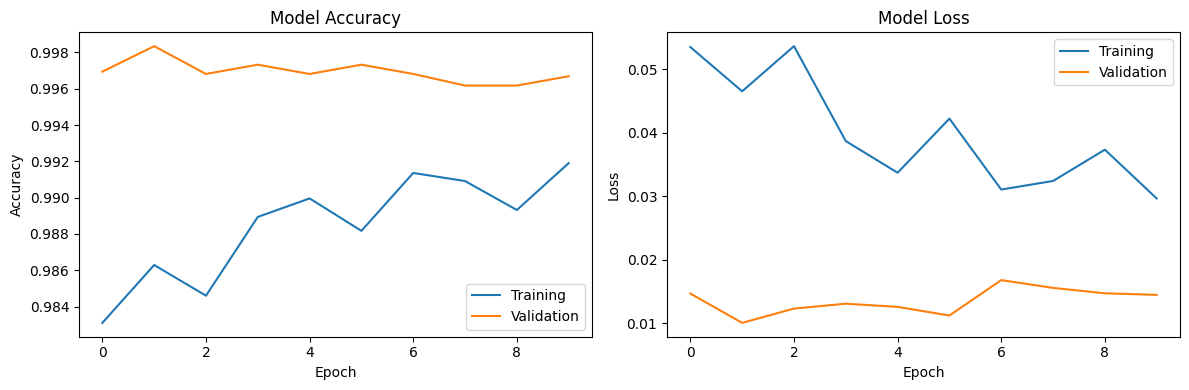

In [11]:
# Hücre 8
import matplotlib.pyplot as plt
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# Eğitim Doğruluğu
plt.plot(history.history['accuracy'], label='Training')
# Doğrulama Doğruluğu
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Hücre 9 - Model kaydetme
model_path = '/content/Traffic_signs_model.keras'
model.save(model_path)
print("Model kaydedildi:", model_path)

# Kaydedilen dosyaları göster
!ls -la /content | sed -n '1,200p'


Model kaydedildi: /content/Traffic_signs_model.keras
total 13284
drwxr-xr-x 1 root root     4096 Oct  2 14:35 .
drwxr-xr-x 1 root root     4096 Oct  2 14:31 ..
drwxr-xr-x 4 root root     4096 Sep 30 13:38 .config
drwxr-xr-x 8 root root     4096 Oct  2 14:34 dataset
-rw-r--r-- 1 root root       70 Oct  2 14:32 kaggle.json
drwxr-xr-x 1 root root     4096 Sep 30 13:39 sample_data
-rw-r--r-- 1 root root 13575020 Oct  2 14:35 Traffic_signs_model.keras


In [10]:
# Hücre 10 - Tek görüntü için inference fonksiyonu
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
class_map = None

def inference_single(image_path, model_path='/content/Traffic_signs_model.keras', img_size=IMG_SIZE, class_map=None):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Görüntü okunamadı: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    x = img.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    model = load_model(model_path)
    preds = model.predict(x)
    prob = float(np.max(preds))
    label_idx = int(np.argmax(preds))
    label_name = class_map[label_idx] if (class_map is not None and label_idx in class_map) else str(label_idx)
    return label_name, prob

# Örnek kullanım
example = None
for root, dirs, files in os.walk('/content/dataset'):
    for f in files[:1]:
        if f.lower().endswith(('.png','.ppm','.jpg','.jpeg')):
            example = os.path.join(root,f)
            break
    if example:
        break

if example:
    print("Örnek dosyada inference çalıştırılıyor:", example)
    print(inference_single(example, model_path=model_path, img_size=IMG_SIZE, class_map=class_map))
else:
    print("Örnek görüntü bulunamadı; kendi test görselini path ile vererek deneyin.")


Örnek dosyada inference çalıştırılıyor: /content/dataset/meta/3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
('6', 0.49821650981903076)
